<a href="https://colab.research.google.com/github/mb1te/SMPR/blob/main/SMPR_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ЗАДАНИЕ 11. ЛИНЕЙНЫЙ ДИСКРИМИНАНТ ФИШЕРА.**

Линейный дискриминант Фишера является частным случаем подстановочного алгоритма, когда матрицы ковариации всех классов равны.
В этом случае матрицу ковариации можно восстановить формуле: $\Sigma = \frac{1}{m-|Y|} \sum\limits_{i=1}^m (x_i - \mu_{y_i}) (x_i - \mu_{y_i})^T$.

Классификатор: $a(x) = arg \max\limits_{y \in Y} (ln(\lambda_y P_y) - \frac{1}{2} \mu_{y_i}^T \Sigma^{-1}\mu_{y_i} + x^T \Sigma_{-1} \mu_{y_i})$.

Этот классификатор проводит разделение прямой, а не кривой, как Plug-In.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

"""
Классифиатор, обучаемый линейным дискриминантом Фишера
"""
class FisherLinearDiscriminant:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.train()

    """
    Метод считает вероятности принадлжености объекта к классу
    """
    @staticmethod
    def p(x, mu, cov):
        x = np.array([x])
        mu = np.array([mu])
        inv = np.linalg.inv(cov)
        return -0.5 * np.matmul(np.matmul(mu, inv), mu.T) + np.matmul(np.matmul(x, inv), mu.T)

    """
    Вычисление мат ожидание, ковариации и приорных вероятностей
    """
    def train(self):
        self.m, self.k = self.X.shape
        
        self.classes = pd.unique(self.y)
        self.mu = {}
        self.cov = np.zeros((self.k, self.k))
        self.prior = {}
        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()
            self.prior[c] = len(self.X.iloc[self.y[self.y == c].index]) / self.m
        
        for i in range(self.m):
            mu = self.mu[self.y.values[i]]
            cur = self.X.values[i]
            self.cov += np.array([cur - mu]) * np.transpose(np.array([cur - mu]))
        self.cov /= self.m - self.k

    """
    Классификация нового объекта
    """
    def predict(self, obj):
        posteriors = []
        classes = []

        for c in self.classes:
            prior = np.log(self.prior[c])
            mu = self.mu[c]
            cov = self.cov
            posterior = prior + self.p(obj, mu, cov)
            posteriors.append(posterior)
            classes.append(c)
        return classes[np.argmax(posteriors)]

    """
    Метод рисует карту классификации
    """
    def draw_classification_map(self):
        i, j = 'x', 'y'
        color = {0: 'blue', 1: 'red'}
        fig, ax = plt.subplots()

        for xi in np.arange(0, 1, 0.03):
            for yi in np.arange(0, 1, 0.03):
                cat = self.predict([xi, yi])
                plt.scatter(xi, yi, color='none', edgecolor=color[cat])

        for ind in range(self.m):
            xi = self.X[i].values[ind]
            yi = self.X[j].values[ind]
            cat = self.y.values[ind]
            clr = color[cat]
            plt.scatter(xi, yi, color=clr)

        plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

"""
Классифиатор, обучаемый подстановочным алгоритмом
"""
class BayesPlugIn:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.train()

    """
    Метод рассчитывает плотность по объекты, мат ожиданию и матрице ковариации
    """
    @staticmethod
    def gauss(x, mu, cov):
        xx = np.array([x - mu])
        det = np.linalg.det(cov)
        inv = np.linalg.inv(cov)
        n = len(x)
        return 1 / (np.sqrt((2 * np.pi)**n) * det) * np.exp(-0.5 * np.transpose(xx) * inv * xx)

    """
    Метод считает для каждого мат ожидание, матрицу ковариации и приорную вероятность
    """
    def train(self):
        self.m, self.k = X.shape
        
        self.classes = pd.unique(self.y)
        self.mu = {}
        self.cov = {c: np.zeros((self.k, self.k)) for c in self.classes}
        self.prior = {}
        for c in self.classes:
            self.mu[c] = self.X.iloc[self.y[self.y == c].index].mean()
            
            for cur in self.X.iloc[self.y[self.y == c].index].values:
                self.cov[c] += np.array([(cur - self.mu[c])]) * np.transpose(np.array([cur - self.mu[c]]))
            self.cov[c] /= self.m - 1

            self.prior[c] = len(self.X.iloc[self.y[self.y == c].index]) / self.m

    """
    Метод рассчитывет вероятности принадлежности объекта каждому классу
    и возвращает наиболее вероятный
    """
    def predict(self, obj):
        posteriors = []
        classes = []

        for c in self.classes:
            prior = np.log(self.prior[c])
            mu = self.mu[c]
            cov = self.cov[c]
            posterior = prior + np.sum(np.log(self.gauss(obj, mu, cov)))
            posteriors.append(posterior)
            classes.append(c)
        
        return classes[np.argmax(posteriors)]

    """
    Метод рисует карту классификации [0,1] x [0,1]
    """
    def draw_classification_map(self):
        i, j = 'x', 'y'
        color = {0: 'blue', 1: 'red'}
        fig, ax = plt.subplots()

        for xi in np.arange(0, 1, 0.03):
            for yi in np.arange(0, 1, 0.03):
                cat = self.predict([xi, yi])
                plt.scatter(xi, yi, color='none', edgecolor=color[cat])

        for ind in range(self.m):
            xi = self.X[i].values[ind]
            yi = self.X[j].values[ind]
            cat = self.y.values[ind]
            clr = color[cat]
            plt.scatter(xi, yi, color=clr)

        plt.legend(handles=[Patch(color=color[key], label=key) for key in color])

        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

Сгенерируем выборку с одинаковым распределением, чтобы показать преимущество линейного дисриминанта Фишера:

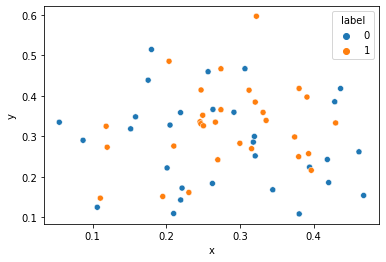

In [ ]:
import numpy as np
import pandas as pd

GROUP_SIZE = 30


"""
Функция generate_array генерирует массив точек заданного размера 
согласно заданным параметрам нормального распределения
"""
def generate_array(m1, d1, m2, d2,  size=GROUP_SIZE):
  return np.concatenate(
    (
      np.random.normal(m1, d1, size=size),
      np.random.normal(m2, d2, size=size)
    )
  )


df = pd.DataFrame(
  {
    'x': generate_array(0.3, 0.1, 0.3, 0.1),
    'y': generate_array(0.3, 0.1, 0.3, 0.1),
    'label': np.array([0] * GROUP_SIZE + [1] * GROUP_SIZE)
  }
)

X = df[['x', 'y']]
y = df.label

import seaborn as sns
sns.scatterplot(data=df, x='x', y='y', hue='label')

Нарисуем карты классификации:

Линейный дискриминант Фишера


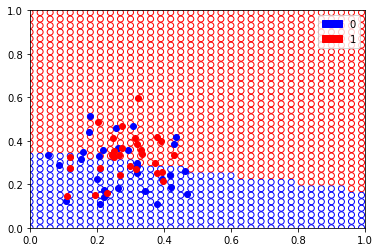

Plug-In алгоритм


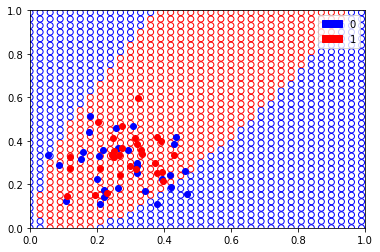

In [ ]:
LDF = FisherLinearDiscriminant(X, y)
print("Линейный дискриминант Фишера")
LDF.draw_classification_map()
BP = BayesPlugIn(X, y)
print("Plug-In алгоритм")
BP.draw_classification_map()


Мы видим, что на выборке с одинаково распределенными классами Plug-In сломался, а ЛДФ смог их разделить получше.

Преимуществом ЛДФ является более высокое качество классификации на выборках с пересекающимися классами. Но в целом эти алгоритмы сравнимы, так как ЛДФ - это частный случай Plug-In.